# Notebook for the Coursera Capstone Project 'Battle of the Neighboorhods'

In [154]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Getting the necessary data

In [86]:
# We will create the dataset from the 23 special  wards by scrapping Wikipedia first

wards_df=pd.read_html('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo')[3]
wards_df = wards_df[['Name', 'Kanji', 'Major districts']][:-1]
wards_df.head()

,Name,Kanji,Major districts
0,Chiyoda,千代田区,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,..."
1,Chūō,中央区,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb..."
2,Minato,港区,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong..."
3,Shinjuku,新宿区,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich..."
4,Bunkyō,文京区,"Hongō, Yayoi, Hakusan"


We only want the biggest district in each ward, so I will remove all entries except the first one from the Major districts list

In [87]:
#wards_df['Major_district'] = [wards_df['Major districts'].split(',')[0] for i in range(len(wards_df))]

major_dist = []
for i in range(len(wards_df)):
    major_dist.append(wards_df.iloc[i]['Major districts'].split(',')[0])
    
wards_df['Major district'] = major_dist
wards_df.head(10)

,Name,Kanji,Major districts,Major district
0,Chiyoda,千代田区,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",Nagatachō
1,Chūō,中央区,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...",Nihonbashi
2,Minato,港区,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...",Odaiba
3,Shinjuku,新宿区,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...",Shinjuku
4,Bunkyō,文京区,"Hongō, Yayoi, Hakusan",Hongō
5,Taitō,台東区,"Ueno, Asakusa",Ueno
6,Sumida,墨田区,"Kinshichō, Morishita, Ryōgoku",Kinshichō
7,Kōtō,江東区,"Kiba, Ariake, Kameido, Tōyōchō, Monzennakachō,...",Kiba
8,Shinagawa,品川区,"Shinagawa, Gotanda, Ōsaki, Hatanodai, Ōimachi,...",Shinagawa
9,Meguro,目黒区,"Meguro, Nakameguro, Jiyugaoka, Komaba, Aobadai",Meguro


We will concentrate only on the most central wards, so I will remove here all unnecessary wards.

In [89]:
wards_df = wards_df.loc[wards_df['Name'].isin(['Chiyoda', 'Chūō', 'Bunkyō', 'Minato', 'Taitō', 'Shinjuku', 'Meguro', 'Shibuya', 'Shinagawa'])]
wards_df

,Name,Kanji,Major districts,Major district
0,Chiyoda,千代田区,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",Nagatachō
1,Chūō,中央区,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...",Nihonbashi
2,Minato,港区,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...",Odaiba
3,Shinjuku,新宿区,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...",Shinjuku
4,Bunkyō,文京区,"Hongō, Yayoi, Hakusan",Hongō
5,Taitō,台東区,"Ueno, Asakusa",Ueno
9,Meguro,目黒区,"Meguro, Nakameguro, Jiyugaoka, Komaba, Aobadai",Meguro
12,Shibuya,渋谷区,"Shibuya, Ebisu, Harajuku, Daikanyama, Hiroo, S...",Shibuya


I will add the location data by hand for these major districts

In [90]:
latitude = [35.6758, 35.6812, 35.6206, 35.6938, 35.7088, 35.7087, 35.6415, 35.6620]
longitude = [139.7435, 139.7742, 139.7805, 139.7034, 139.7601, 139.7742, 139.6981, 139.7038]
wards_df['Latitude'] = latitude
wards_df['Longitude'] = longitude
wards_df

,Name,Kanji,Major districts,Major district,Latitude,Longitude
0,Chiyoda,千代田区,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",Nagatachō,35.6758,139.7435
1,Chūō,中央区,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...",Nihonbashi,35.6812,139.7742
2,Minato,港区,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...",Odaiba,35.6206,139.7805
3,Shinjuku,新宿区,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...",Shinjuku,35.6938,139.7034
4,Bunkyō,文京区,"Hongō, Yayoi, Hakusan",Hongō,35.7088,139.7601
5,Taitō,台東区,"Ueno, Asakusa",Ueno,35.7087,139.7742
9,Meguro,目黒区,"Meguro, Nakameguro, Jiyugaoka, Komaba, Aobadai",Meguro,35.6415,139.6981
12,Shibuya,渋谷区,"Shibuya, Ebisu, Harajuku, Daikanyama, Hiroo, S...",Shibuya,35.6620,139.7038


In [129]:
# Lets get the coffe shops for the area
# create map of Toronto using latitude and longitude values
map_tokyo_reduced = folium.Map(location=[35.6762, 139.75], zoom_start=12)

# add markers to map
for lat, lng, name in zip(wards_df['Latitude'], wards_df['Longitude'], wards_df['Major district']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo_reduced)  
    
map_tokyo_reduced

# Getting the data from Foursquare

In [1]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [163]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d1e0931735'.format(
            CLIENT_ID,
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            400)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [164]:
tokyo_cafes = getNearbyVenues(names=wards_df['Major district'],
                                   latitudes=wards_df['Latitude'],
                                   longitudes=wards_df['Longitude'],
                                  )
print(tokyo_cafes.shape)
tokyo_cafes.head()

Nagatachō
Nihonbashi
Odaiba
Shinjuku
Hongō
Ueno
Meguro
Shibuya
(757, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nagatachō,35.6758,139.7435,4b53c3b8f964a520b5aa27e3,Starbucks,35.672974,139.736623,Coffee Shop
1,Nagatachō,35.6758,139.7435,57c66b5f498e64f52d32aa62,La Précieuse,35.679796,139.737664,Café
2,Nagatachō,35.6758,139.7435,58895063297c1604b1ed44e1,tiny peace kitchen,35.679939,139.739664,Café
3,Nagatachō,35.6758,139.7435,5731d701498ed5592d7d4bc1,Starbucks,35.679223,139.737529,Coffee Shop
4,Nagatachō,35.6758,139.7435,56e7e6b5498e3c97d4cca603,Unir,35.671811,139.737684,Coffee Shop


In [165]:
tokyo_cafes.to_csv('tokyo_cafes.csv')

In [168]:
tokyo_cafes

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nagatachō,35.6758,139.7435,4b53c3b8f964a520b5aa27e3,Starbucks,35.672974,139.736623,Coffee Shop
1,Nagatachō,35.6758,139.7435,57c66b5f498e64f52d32aa62,La Précieuse,35.679796,139.737664,Café
2,Nagatachō,35.6758,139.7435,58895063297c1604b1ed44e1,tiny peace kitchen,35.679939,139.739664,Café
3,Nagatachō,35.6758,139.7435,5731d701498ed5592d7d4bc1,Starbucks,35.679223,139.737529,Coffee Shop
4,Nagatachō,35.6758,139.7435,56e7e6b5498e3c97d4cca603,Unir,35.671811,139.737684,Coffee Shop
5,Nagatachō,35.6758,139.7435,5ad2a80cee712066bb785a37,GLITCH COFFEE BREWED,35.673873,139.735235,Coffee Shop
6,Nagatachō,35.6758,139.7435,53b0fbe3498eec2a46cecf46,Aoyama Flower Market Tea House (青山フラワーマーケット ティ...,35.673082,139.736435,Café
7,Nagatachō,35.6758,139.7435,50057c2be4b0f1ca8f39869e,Kaisu,35.669896,139.734565,Café
8,Nagatachō,35.6758,139.7435,4e3a5581d22d4aca878d99f3,Garden Lounge (ガーデンラウンジ),35.679817,139.734962,Café
9,Nagatachō,35.6758,139.7435,4b56e1ecf964a5200a1e28e3,Kojimachi Cafe (麹町カフェ),35.683721,139.741569,Café


# Exploratory data analysis


In [167]:
# Lets get the coffe shops for the area
map_tokyo_cafes = folium.Map(location=[35.6762, 139.75], zoom_start=12)

# add markers to map
for lat, lng, name in zip(tokyo_cafes['Venue Latitude'], tokyo_cafes['Venue Longitude'], tokyo_cafes['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo_cafes)  
    
map_tokyo_cafes

In [169]:
print (tokyo_cafes['Venue'].value_counts())

Starbucks                                                         91
Tully's Coffee                                                    14
Blue Bottle Coffee                                                11
Ueshima Coffee House (上島珈琲店)                                      10
Coffee Room Renoir (喫茶室ルノアール)                                      9
DEAN & DELUCA                                                      8
Sarutahiko Coffee (猿田彦珈琲)                                          7
Komeda's Coffee (コメダ珈琲店)                                           6
Yanaka Coffee (やなか珈琲店)                                             6
Starbucks Reserve Bar                                              5
Rose Bakery                                                        4
Doutor Coffee Shop (ドトールコーヒーショップ)                                  4
HARBS                                                              4
DIXANS                                                             4
A Happy Pancake (幸せのパンケーキ)        

In [170]:
freq_df=tokyo_cafes['Venue'].value_counts().to_frame(name='frequency')
freq_df=freq_df.reset_index()

freq_df.rename(index=str, columns={"index": "Venue name", "frequency": "Frequency"}, inplace=True)
freq_df

,Venue name,Frequency
0,Starbucks,91
1,Tully's Coffee,14
2,Blue Bottle Coffee,11
3,Ueshima Coffee House (上島珈琲店),10
4,Coffee Room Renoir (喫茶室ルノアール),9
5,DEAN & DELUCA,8
6,Sarutahiko Coffee (猿田彦珈琲),7
7,Komeda's Coffee (コメダ珈琲店),6
8,Yanaka Coffee (やなか珈琲店),6
9,Starbucks Reserve Bar,5


/Users/pierrewuethrich/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pierrewuethrich/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 23798 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pierrewuethrich/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 29640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pierrewuethrich/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 29746 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pierrewuethrich/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pierrewuethrich/anaconda3/li

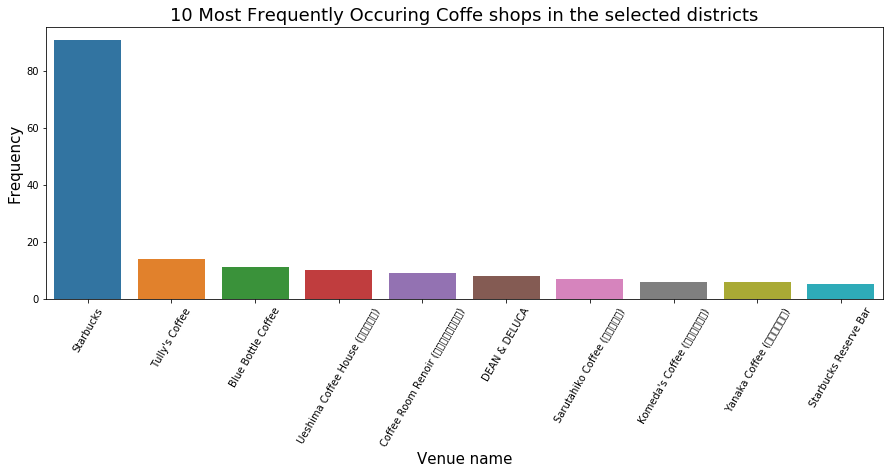

In [171]:
fig = plt.figure(figsize=(15,5))
s=sns.barplot(x="Venue name", y="Frequency", data=freq_df[:10])
s.set_xticklabels(s.get_xticklabels(), rotation=60)
plt.title('10 Most Frequently Occuring Coffe shops in the selected districts', fontsize=18)
plt.xlabel("Venue name", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.show()

# Clustering the areas on most frequent coffe shops

In [175]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_cafes[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Major district'] = tokyo_cafes['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

tokyo_onehot.head()
tokyo_onehot.shape

(757, 452)

In [176]:
tokyo_grouped = tokyo_onehot.groupby('Major district').mean().reset_index()
tokyo_grouped.shape

(8, 452)

In [180]:
num_top_venues = 5

for hood in tokyo_grouped['Major district']:
    print("----"+hood+"----")
    temp = tokyo_grouped[tokyo_grouped['Major district'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Hongō----
                          venue  freq
0                     Starbucks  0.06
1  Ueshima Coffee House (上島珈琲店)  0.03
2        Yanaka Coffee (やなか珈琲店)  0.02
3                        DIXANS  0.02
4                Tully's Coffee  0.02


----Meguro----
                       venue  freq
0                  Starbucks  0.13
1         Blue Bottle Coffee  0.03
2  Sarutahiko Coffee (猿田彦珈琲)  0.02
3              DEAN & DELUCA  0.02
4                 NICK STOCK  0.01


----Nagatachō----
                           venue  freq
0                      Starbucks  0.19
1   Ueshima Coffee House (上島珈琲店)  0.02
2          Starbucks Reserve Bar  0.02
3  Coffee Room Renoir (喫茶室ルノアール)  0.02
4       St. Marc Café (サンマルクカフェ)  0.02


----Nihonbashi----
                           venue  freq
0                      Starbucks  0.20
1             Blue Bottle Coffee  0.02
2                    Rose Bakery  0.02
3  Coffee Room Renoir (喫茶室ルノアール)  0.02
4         Saryo Tsujiri (茶寮 都路里)  0.01


----Odaiba----
     

In [181]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [186]:
num_top_venues = 10

# create columns according to number of top venues
columns = ['Major district']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
major_districts_venues_sorted = pd.DataFrame(columns=columns)
major_districts_venues_sorted['Major district'] = tokyo_grouped['Major district']

for ind in np.arange(tokyo_grouped.shape[0]):
    major_districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

major_districts_venues_sorted.head(10)

,Major district,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hongō,Starbucks,Ueshima Coffee House (上島珈琲店),Tully's Coffee,DIXANS,Yanaka Coffee (やなか珈琲店),Espresso Factory,Sarutahiko Coffee (猿田彦珈琲),Park Side Cafe,Fukumori (フクモリ),Cafe Mai:lish
1,Meguro,Starbucks,Blue Bottle Coffee,DEAN & DELUCA,Sarutahiko Coffee (猿田彦珈琲),Cafe Park,YEBISU GARDEN CAFE,Photobook Diner Megutama (写真集食堂 めぐたま),accueil (アクイーユ),Perch by Woodberry Coffee Roasters,anea cafe 学芸大学店
2,Nagatachō,Starbucks,Ueshima Coffee House (上島珈琲店),Rose Bakery,DEAN & DELUCA,Starbucks Reserve Bar,Blue Bottle Coffee,Coffee Room Renoir (喫茶室ルノアール),St. Marc Café (サンマルクカフェ),Honolulu Coffee,illy CAFFÉ
3,Nihonbashi,Starbucks,Blue Bottle Coffee,Coffee Room Renoir (喫茶室ルノアール),Rose Bakery,The Lobby,Tsuki no Hanare (月光荘サロン 月のはなれ),Takayama Coffee (高山珈琲),Terrace 8890 (テラス ハチハチキュウゼロ),The Cafe by AMAN,The City Bakery
4,Odaiba,Starbucks,Tully's Coffee,PRONTO,Doutor Coffee Shop (ドトールコーヒーショップ),青海珈琲,Quatre お台場店,Cafe Terrace Royal (カフェテラスロイヤル),Island Vintage Coffee,RUBY CAFE,Cafe La Bohéme
5,Shibuya,Starbucks,Ueshima Coffee House (上島珈琲店),Maruyama Coffee (丸山珈琲),Streamer Coffee Company,Sarutahiko Coffee (猿田彦珈琲),Verde (ヴェルデ),RH cafe,Coffee Elementary School (私立珈琲小学校),WEEKEND GARAGE TOKYO,WIRED TOKYO 1999
6,Shinjuku,Starbucks,Komeda's Coffee (コメダ珈琲店),Tajimaya Coffee (但馬屋珈琲店),Segafredo Zanetti Espresso,Tully's Coffee,Coffee Room Renoir (喫茶室ルノアール),Café & Meal MUJI,Counterpart Coffee Gallery,Edinburgh (珈琲貴族エジンバラ),EXCELSIOR CAFFÉ Barista
7,Ueno,Starbucks,Tully's Coffee,Yanaka Coffee (やなか珈琲店),Coffee Room Renoir (喫茶室ルノアール),DIXANS,Kappabashi Coffee & Bar,maidreamin (ひみつきち),Galant (ギャラン),JAM Akihabara,iriya plus café (イリヤプラスカフェ)


# Clustering the districts according to coffee shops

In [192]:
# set number of clusters
kclusters = 4

tokyo_grouped_clustering = tokyo_grouped.drop('Major district', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 1, 1, 3, 2, 2, 0], dtype=int32)

In [193]:
# add clustering labels
major_districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tokyo_merged = wards_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each major district
tokyo_merged = tokyo_merged.join(major_districts_venues_sorted.set_index('Major district'), on='Major district')

tokyo_merged.head() # check the last columns!

,Name,Kanji,Major districts,Major district,Latitude,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chiyoda,千代田区,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",Nagatachō,35.6758,139.7435,1,Starbucks,Ueshima Coffee House (上島珈琲店),Rose Bakery,DEAN & DELUCA,Starbucks Reserve Bar,Blue Bottle Coffee,Coffee Room Renoir (喫茶室ルノアール),St. Marc Café (サンマルクカフェ),Honolulu Coffee,illy CAFFÉ
1,Chūō,中央区,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...",Nihonbashi,35.6812,139.7742,1,Starbucks,Blue Bottle Coffee,Coffee Room Renoir (喫茶室ルノアール),Rose Bakery,The Lobby,Tsuki no Hanare (月光荘サロン 月のはなれ),Takayama Coffee (高山珈琲),Terrace 8890 (テラス ハチハチキュウゼロ),The Cafe by AMAN,The City Bakery
2,Minato,港区,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...",Odaiba,35.6206,139.7805,3,Starbucks,Tully's Coffee,PRONTO,Doutor Coffee Shop (ドトールコーヒーショップ),青海珈琲,Quatre お台場店,Cafe Terrace Royal (カフェテラスロイヤル),Island Vintage Coffee,RUBY CAFE,Cafe La Bohéme
3,Shinjuku,新宿区,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...",Shinjuku,35.6938,139.7034,2,Starbucks,Komeda's Coffee (コメダ珈琲店),Tajimaya Coffee (但馬屋珈琲店),Segafredo Zanetti Espresso,Tully's Coffee,Coffee Room Renoir (喫茶室ルノアール),Café & Meal MUJI,Counterpart Coffee Gallery,Edinburgh (珈琲貴族エジンバラ),EXCELSIOR CAFFÉ Barista
4,Bunkyō,文京区,"Hongō, Yayoi, Hakusan",Hongō,35.7088,139.7601,0,Starbucks,Ueshima Coffee House (上島珈琲店),Tully's Coffee,DIXANS,Yanaka Coffee (やなか珈琲店),Espresso Factory,Sarutahiko Coffee (猿田彦珈琲),Park Side Cafe,Fukumori (フクモリ),Cafe Mai:lish


In [206]:
# create map
map_tokyo_clustered = folium.Map(location=[35.6762, 139.75], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged['Latitude'], tokyo_merged['Longitude'], tokyo_merged['Major district'], tokyo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-3],
        fill_opacity=0.7).add_to(map_tokyo_clustered)
       
map_tokyo_clustered